In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brainwave/emotions.csv


In [2]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/kaggle/input/brainwave/emotions.csv')

# Inspect the first few rows
print(data.head())


   # mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_d_0_a  mean_d_1_a  \
0        4.62      30.3    -356.0      15.6      26.3       1.070       0.411   
1       28.80      33.1      32.0      25.8      22.8       6.550       1.680   
2        8.90      29.4    -416.0      16.7      23.7      79.900       3.360   
3       14.90      31.6    -143.0      19.8      24.3      -0.584      -0.284   
4       28.30      31.3      45.2      27.3      24.5      34.800      -5.790   

   mean_d_2_a  mean_d_3_a  mean_d_4_a  ...  fft_741_b  fft_742_b  fft_743_b  \
0      -15.70        2.06        3.15  ...       23.5       20.3       20.3   
1        2.88        3.83       -4.82  ...      -23.3      -21.8      -21.8   
2       90.20       89.90        2.03  ...      462.0     -233.0     -233.0   
3        8.82        2.30       -1.97  ...      299.0     -243.0     -243.0   
4        3.06       41.40        5.52  ...       12.0       38.1       38.1   

   fft_744_b  fft_745_b  fft_746_b  ff

In [ ]:
print(data.columns.tolist())  # Only column names

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
# Separate features (X) and labels (y)
X = data.drop(columns=['label'])  # Features
y = data['label']  # Labels

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
from sklearn.preprocessing import LabelEncoder

# Encode the target labels (NEGATIVE -> 0, NEUTRAL -> 1, POSITIVE -> 2)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Check encoding mapping
print("Label Encoding Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


In [ ]:
# Apply LASSO for feature selection
alpha = 0.01  # Regularization strength (adjust as needed)
lasso = Lasso(alpha=alpha)
lasso.fit(X_scaled, y)

# Identify selected features (non-zero coefficients)
selected_features_indices = np.where(lasso.coef_ != 0)[0]
selected_features = X.columns[selected_features_indices]
print(f"Selected {len(selected_features)} features: {selected_features}")

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Define models
def get_models():
    return {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "Decision Tree": DecisionTreeClassifier(),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "SVM": SVC(kernel='linear', probability=True),
        "AdaBoost": AdaBoostClassifier(n_estimators=100),
        "Gaussian Naive Bayes": GaussianNB(),
        "LightGBM": lgb.LGBMClassifier(),
        "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "CatBoost": cb.CatBoostClassifier(verbose=0)
    }

# Train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test):
    models = get_models()
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1 = report['macro avg']['f1-score']
        
        # Store results
        results[name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Training Time (s)": training_time
        }
        
        # Print results
        print(f"{name} Accuracy: {accuracy:.4f}")
        print(f"{name} Precision: {precision:.4f}")
        print(f"{name} Recall: {recall:.4f}")
        print(f"{name} F1 Score: {f1:.4f}")
        print(f"Training Time: {training_time:.4f} seconds\n")
    
    # Plot results
    plot_comparison(results)
    
    return results

# Function to plot comparison graphs
def plot_comparison(results):
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Training Time (s)"]
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 2, i)
        sorted_results = sorted(results.items(), key=lambda x: x[1][metric], reverse=True)
        models = [x[0] for x in sorted_results]
        scores = [x[1][metric] for x in sorted_results]
        
        sns.lineplot(x=models, y=scores, marker='o', linestyle='-', markersize=8)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(metric)
        plt.title(f'Model Comparison: {metric}')
        
    plt.tight_layout()
    plt.show()

# Example usage (assuming X_train, X_test, y_train, y_test are defined)
results = train_evaluate_models(X_train, X_test, y_train, y_test)


In [ ]:
import matplotlib.pyplot as plt

# Convert results to a structured format for plotting
import pandas as pd

# Create DataFrame from results dictionary
results_df = pd.DataFrame(results).T  # Transpose to get models as rows
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1 Score", "Training Time (s)"]

# Plot each metric
plt.figure(figsize=(15, 8))
for idx, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 3, idx+1)
    results_df[metric].sort_values().plot(kind='barh', color='skyblue')
    plt.title(metric)
    plt.xlabel(metric)
    plt.ylabel("Model")
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Model Comparison Metrics", fontsize=18, y=1.02)
plt.show()


In [ ]:
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd

# Apply Ridge Regression
alpha = 0.6  # Regularization strength
ridge = Ridge(alpha=alpha)
ridge.fit(X_scaled, y)

# Get absolute coefficients
coef_abs = np.abs(ridge.coef_)

# Select top-N important features
N = 20  # adjust as needed
top_n_indices = np.argsort(coef_abs)[-N:]  # indices of top-N coefficients
selected_features = X.columns[top_n_indices]

print(f"Top {N} selected features based on Ridge coefficients:")
print(selected_features)


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Define models
def get_models():
    return {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "Decision Tree": DecisionTreeClassifier(),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "SVM": SVC(kernel='linear', probability=True),
        "AdaBoost": AdaBoostClassifier(n_estimators=100),
        "Gaussian Naive Bayes": GaussianNB(),
        "LightGBM": lgb.LGBMClassifier(),
        "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "CatBoost": cb.CatBoostClassifier(verbose=0)
    }

# Train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test):
    models = get_models()
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1 = report['macro avg']['f1-score']
        
        # Store results
        results[name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Training Time (s)": training_time
        }
        
        # Print results
        print(f"{name} Accuracy: {accuracy:.4f}")
        print(f"{name} Precision: {precision:.4f}")
        print(f"{name} Recall: {recall:.4f}")
        print(f"{name} F1 Score: {f1:.4f}")
        print(f"Training Time: {training_time:.4f} seconds\n")
    
    # Plot results
    plot_comparison(results)
    
    return results

# Function to plot comparison graphs
def plot_comparison(results):
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Training Time (s)"]
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 2, i)
        sorted_results = sorted(results.items(), key=lambda x: x[1][metric], reverse=True)
        models = [x[0] for x in sorted_results]
        scores = [x[1][metric] for x in sorted_results]
        
        sns.lineplot(x=models, y=scores, marker='o', linestyle='-', markersize=8)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(metric)
        plt.title(f'Model Comparison: {metric}')
        
    plt.tight_layout()
    plt.show()

# Example usage (assuming X_train, X_test, y_train, y_test are defined)
results = train_evaluate_models(X_train, X_test, y_train, y_test)


In [ ]:
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd

# Apply Ridge Regression
alpha = 0.6  # Regularization strength
ridge = Ridge(alpha=alpha)
ridge.fit(X_scaled, y)

# Get absolute coefficients
coef_abs = np.abs(ridge.coef_)

# Select top-N important features
N = 50  # adjust as needed
top_n_indices = np.argsort(coef_abs)[-N:]  # indices of top-N coefficients
selected_features = X.columns[top_n_indices]

print(f"Top {N} selected features based on Ridge coefficients:")
print(selected_features)


In [ ]:
# Subset the dataset with selected features
X = X_scaled[:, top_n_indices]

# Split the feature-selected data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Define models
def get_models():
    return {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "Decision Tree": DecisionTreeClassifier(),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "SVM": SVC(kernel='linear', probability=True),
        "AdaBoost": AdaBoostClassifier(n_estimators=100),
        "Gaussian Naive Bayes": GaussianNB(),
        "LightGBM": lgb.LGBMClassifier(),
        "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "CatBoost": cb.CatBoostClassifier(verbose=0)
    }

# Train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test):
    models = get_models()
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1 = report['macro avg']['f1-score']
        
        # Store results
        results[name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Training Time (s)": training_time
        }
        
        # Print results
        print(f"{name} Accuracy: {accuracy:.4f}")
        print(f"{name} Precision: {precision:.4f}")
        print(f"{name} Recall: {recall:.4f}")
        print(f"{name} F1 Score: {f1:.4f}")
        print(f"Training Time: {training_time:.4f} seconds\n")
    
    # Plot results
    plot_comparison(results)
    
    return results

# Function to plot comparison graphs
def plot_comparison(results):
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Training Time (s)"]
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 2, i)
        sorted_results = sorted(results.items(), key=lambda x: x[1][metric], reverse=True)
        models = [x[0] for x in sorted_results]
        scores = [x[1][metric] for x in sorted_results]
        
        sns.lineplot(x=models, y=scores, marker='o', linestyle='-', markersize=8)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(metric)
        plt.title(f'Model Comparison: {metric}')
        
    plt.tight_layout()
    plt.show()

# Example usage (assuming X_train, X_test, y_train, y_test are defined)
results = train_evaluate_models(X_train, X_test, y_train, y_test)


In [3]:
df = data

In [4]:
import pandas as pd
import re

# Assuming df is your DataFrame
feature_groups = {
    'mean_features': [col for col in df.columns if re.match(r'mean_', col)],
    'stddev_features': [col for col in df.columns if re.match(r'stddev_', col)],
    'moment_features': [col for col in df.columns if re.match(r'moments_', col)],
    'fft_features': [col for col in df.columns if re.match(r'fft_', col)],
    'covmat_features': [col for col in df.columns if re.match(r'covmat_', col)],
    'eigen_features': [col for col in df.columns if re.match(r'eigen_', col)],
    'entropy_features': [col for col in df.columns if re.match(r'entropy', col)],
    'correlate_features': [col for col in df.columns if re.match(r'correlate_', col)],
    'minmax_features': [col for col in df.columns if re.match(r'(min|max)_', col)],
}

# Print counts
for group, features in feature_groups.items():
    print(f"{group}: {len(features)} features")

mean_features: 119 features
stddev_features: 20 features
moment_features: 40 features
fft_features: 1500 features
covmat_features: 288 features
eigen_features: 24 features
entropy_features: 10 features
correlate_features: 150 features
minmax_features: 240 features


In [5]:
import pandas as pd
import re

# Assuming df is your DataFrame
mean_std_features = [col for col in df.columns if re.match(r'(mean_|stddev_', col)]

# Select only those columns
df_mean_std = df[mean_std_features]

# Print how many features were selected
print(f"Total mean + stddev features selected: {len(mean_std_features)}")


Total mean + stddev features selected: 139


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assume df is already loaded and includes a target column named 'target'
# Replace 'target' with your actual target column name


# Step 3: Separate features and target
X = df_mean_std  # Replace 'target' with your actual label column
y = df['label']
from sklearn.preprocessing import LabelEncoder

# Encode the target labels (NEGATIVE -> 0, NEUTRAL -> 1, POSITIVE -> 2)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Check encoding mapping
print("Label Encoding Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirmation
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")


Label Encoding Mapping: {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
Shape of X_train: (1705, 139)
Shape of X_test: (427, 139)


Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.9555
Logistic Regression Precision: 0.9549
Logistic Regression Recall: 0.9547
Logistic Regression F1 Score: 0.9548
Training Time: 5.1239 seconds

Training Random Forest...
Random Forest Accuracy: 0.9906
Random Forest Precision: 0.9904
Random Forest Recall: 0.9904
Random Forest F1 Score: 0.9904
Training Time: 1.0223 seconds

Training Decision Tree...
Decision Tree Accuracy: 0.9742
Decision Tree Precision: 0.9742
Decision Tree Recall: 0.9738
Decision Tree F1 Score: 0.9739
Training Time: 0.1597 seconds

Training KNN...
KNN Accuracy: 0.9321
KNN Precision: 0.9348
KNN Recall: 0.9299
KNN F1 Score: 0.9300
Training Time: 0.0055 seconds

Training AdaBoost...
AdaBoost Accuracy: 0.8829
AdaBoost Precision: 0.8839
AdaBoost Recall: 0.8812
AdaBoost F1 Score: 0.8819
Training Time: 2.8518 seconds

Training Gaussian Naive Bayes...
Gaussian Naive Bayes Accuracy: 0.7681
Gaussian Naive Bayes Precision: 0.7636
Gaussian Naive Bayes Recall: 0.7650
Gaussian Naive Bayes F1 Score: 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

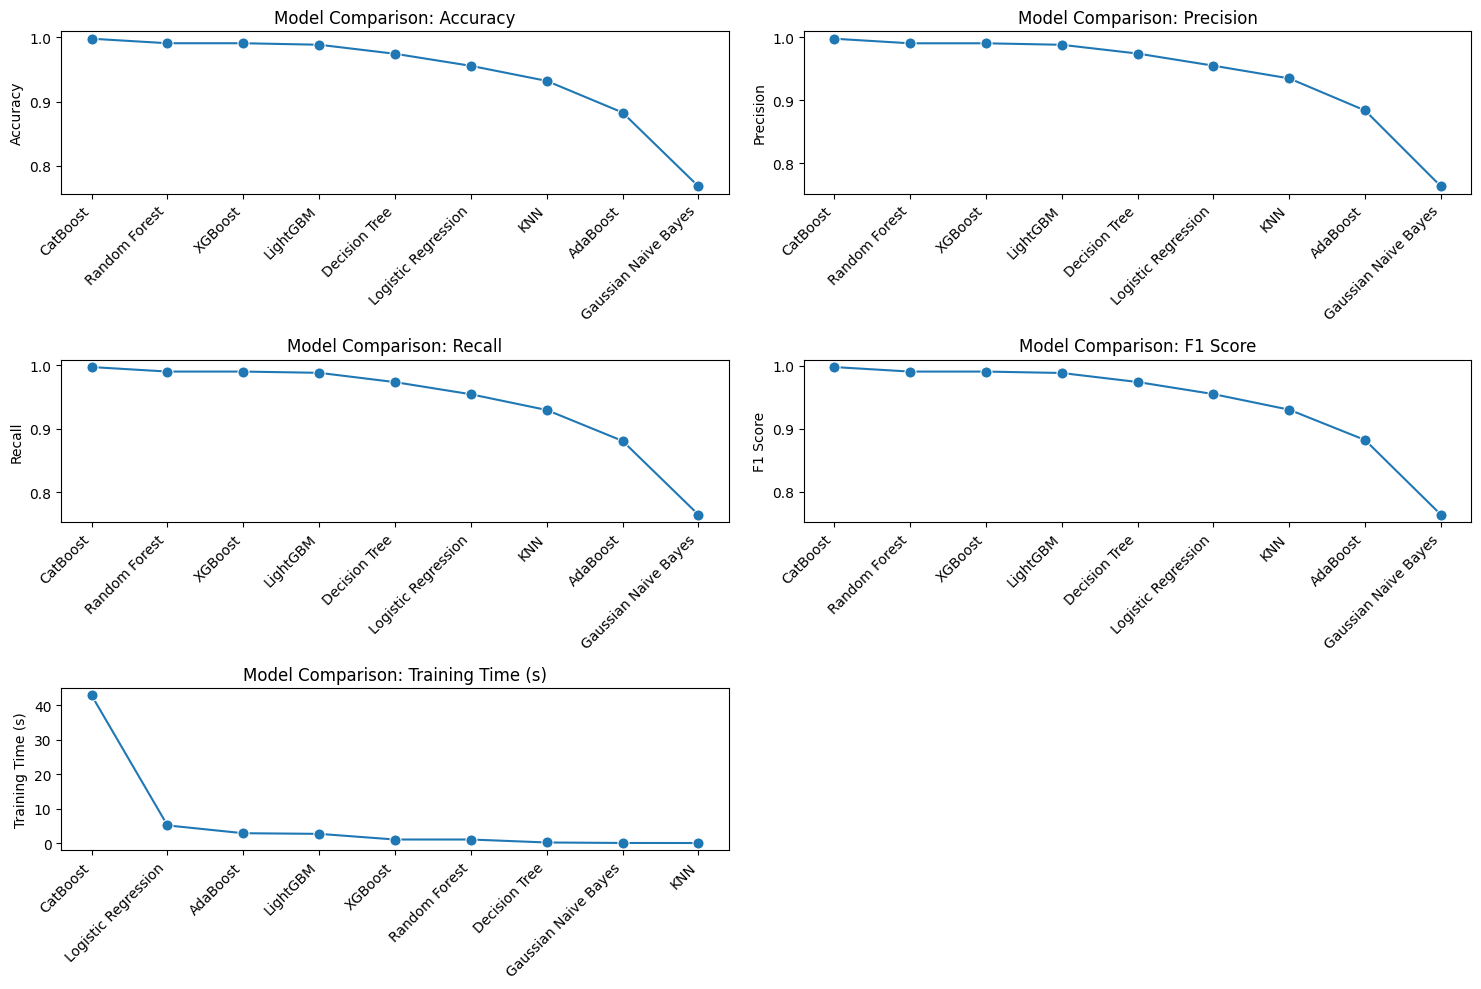

NameError: name 'in_test_split' is not defined

In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Define models
def get_models():
    return {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "Decision Tree": DecisionTreeClassifier(),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "AdaBoost": AdaBoostClassifier(n_estimators=100),
        "Gaussian Naive Bayes": GaussianNB(),
        "LightGBM": lgb.LGBMClassifier(),
        "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "CatBoost": cb.CatBoostClassifier(verbose=0)
    }

# Train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test):
    models = get_models()
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1 = report['macro avg']['f1-score']
        
        # Store results
        results[name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Training Time (s)": training_time
        }
        
        # Print results
        print(f"{name} Accuracy: {accuracy:.4f}")
        print(f"{name} Precision: {precision:.4f}")
        print(f"{name} Recall: {recall:.4f}")
        print(f"{name} F1 Score: {f1:.4f}")
        print(f"Training Time: {training_time:.4f} seconds\n")
    
    # Plot results
    plot_comparison(results)
    
    return results

# Function to plot comparison graphs
def plot_comparison(results):
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Training Time (s)"]
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 2, i)
        sorted_results = sorted(results.items(), key=lambda x: x[1][metric], reverse=True)
        models = [x[0] for x in sorted_results]
        scores = [x[1][metric] for x in sorted_results]
        
        sns.lineplot(x=models, y=scores, marker='o', linestyle='-', markersize=8)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(metric)
        plt.title(f'Model Comparison: {metric}')
        
    plt.tight_layout()
    plt.show()

# Example usage (assuming X_train, X_test, y_train, y_test are defined)
results = train_evaluate_models(X_train, X_test, y_train, y_test)
in_test_split(X, y, test_size=0.2, random_state=42)

# Confirmation
print(f"Shape of FFT X_train: {X_train.shape}")
print(f"Shape of FFT X_test: {X_test.shape}")


In [9]:
import pandas as pd
import re

# Assuming df is your DataFrame
mean_std_features = [col for col in df.columns if re.match(r'(mean_|stddev_|(min|max)_)', col)]

# Select only those columns
df_mean_std = df[mean_std_features]

# Print how many features were selected
print(f"Total mean + stddev features selected + +min max : {len(mean_std_features)}")


Total mean + stddev features selected + +min max : 379


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assume df is already loaded and includes a target column named 'target'
# Replace 'target' with your actual target column name


# Step 3: Separate features and target
X = df_mean_std  # Replace 'target' with your actual label column
y = df['label']
from sklearn.preprocessing import LabelEncoder

# Encode the target labels (NEGATIVE -> 0, NEUTRAL -> 1, POSITIVE -> 2)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Check encoding mapping
print("Label Encoding Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirmation
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")


Label Encoding Mapping: {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
Shape of X_train: (1705, 379)
Shape of X_test: (427, 379)


Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.9461
Logistic Regression Precision: 0.9453
Logistic Regression Recall: 0.9452
Logistic Regression F1 Score: 0.9453
Training Time: 7.2945 seconds

Training Random Forest...
Random Forest Accuracy: 0.9930
Random Forest Precision: 0.9929
Random Forest Recall: 0.9928
Random Forest F1 Score: 0.9928
Training Time: 1.6967 seconds

Training Decision Tree...
Decision Tree Accuracy: 0.9625
Decision Tree Precision: 0.9623
Decision Tree Recall: 0.9617
Decision Tree F1 Score: 0.9618
Training Time: 0.4901 seconds

Training KNN...
KNN Accuracy: 0.9251
KNN Precision: 0.9317
KNN Recall: 0.9222
KNN F1 Score: 0.9224
Training Time: 0.0085 seconds

Training AdaBoost...
AdaBoost Accuracy: 0.8431
AdaBoost Precision: 0.8513
AdaBoost Recall: 0.8423
AdaBoost F1 Score: 0.8438
Training Time: 7.5756 seconds

Training Gaussian Naive Bayes...
Gaussian Naive Bayes Accuracy: 0.6628
Gaussian Naive Bayes Precision: 0.6823
Gaussian Naive Bayes Recall: 0.6600
Gaussian Naive Bayes F1 Score: 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

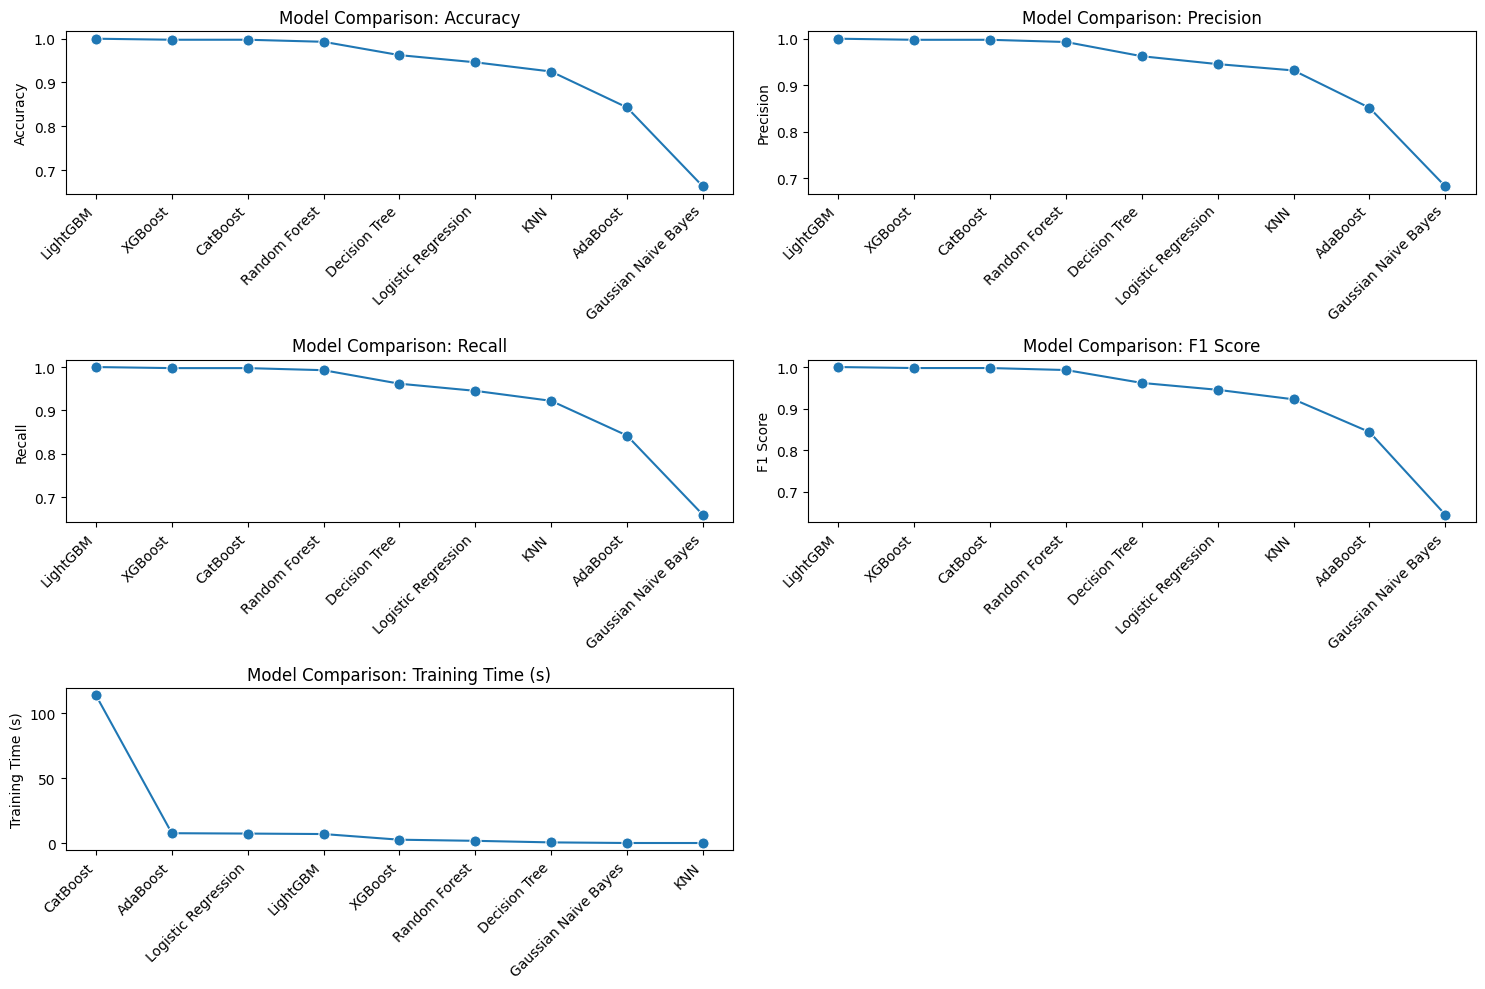

In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Define models
def get_models():
    return {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "Decision Tree": DecisionTreeClassifier(),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "AdaBoost": AdaBoostClassifier(n_estimators=100),
        "Gaussian Naive Bayes": GaussianNB(),
        "LightGBM": lgb.LGBMClassifier(),
        "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "CatBoost": cb.CatBoostClassifier(verbose=0)
    }

# Train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test):
    models = get_models()
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1 = report['macro avg']['f1-score']
        
        # Store results
        results[name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Training Time (s)": training_time
        }
        
        # Print results
        print(f"{name} Accuracy: {accuracy:.4f}")
        print(f"{name} Precision: {precision:.4f}")
        print(f"{name} Recall: {recall:.4f}")
        print(f"{name} F1 Score: {f1:.4f}")
        print(f"Training Time: {training_time:.4f} seconds\n")
    
    # Plot results
    plot_comparison(results)
    
    return results

# Function to plot comparison graphs
def plot_comparison(results):
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Training Time (s)"]
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 2, i)
        sorted_results = sorted(results.items(), key=lambda x: x[1][metric], reverse=True)
        models = [x[0] for x in sorted_results]
        scores = [x[1][metric] for x in sorted_results]
        
        sns.lineplot(x=models, y=scores, marker='o', linestyle='-', markersize=8)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(metric)
        plt.title(f'Model Comparison: {metric}')
        
    plt.tight_layout()
    plt.show()

# Example usage (assuming X_train, X_test, y_train, y_test are defined)
results = train_evaluate_models(X_train, X_test, y_train, y_test)


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assume df is already loaded and includes a target column named 'target'
# Replace 'target' with your actual target column name

# Step 1: Identify all FFT features
fft_features = [col for col in df.columns if col.startswith('fft_')]

# Step 2: Drop FFT features
df_non_fft = df.drop(columns=fft_features)

# Step 3: Separate features and target
X = df_non_fft.drop(columns='label')  # Replace 'target' with your actual label column
y = df_non_fft['label']
from sklearn.preprocessing import LabelEncoder

# Encode the target labels (NEGATIVE -> 0, NEUTRAL -> 1, POSITIVE -> 2)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Check encoding mapping
print("Label Encoding Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirmation
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")


Label Encoding Mapping: {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
Shape of X_train: (1705, 1048)
Shape of X_test: (427, 1048)


Training Logistic Regression...
Logistic Regression Accuracy: 0.3349
Logistic Regression Precision: 0.1116
Logistic Regression Recall: 0.3333
Logistic Regression F1 Score: 0.1673
Training Time: 0.0880 seconds

Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero

Random Forest Accuracy: 0.9906
Random Forest Precision: 0.9906
Random Forest Recall: 0.9903
Random Forest F1 Score: 0.9904
Training Time: 2.7552 seconds

Training Decision Tree...
Decision Tree Accuracy: 0.9672
Decision Tree Precision: 0.9668
Decision Tree Recall: 0.9667
Decision Tree F1 Score: 0.9667
Training Time: 1.3594 seconds

Training KNN...
KNN Accuracy: 0.7611
KNN Precision: 0.7510
KNN Recall: 0.7557
KNN F1 Score: 0.7469
Training Time: 0.0202 seconds

Training AdaBoost...
AdaBoost Accuracy: 0.9180
AdaBoost Precision: 0.9248
AdaBoost Recall: 0.9155
AdaBoost F1 Score: 0.9157
Training Time: 20.7036 seconds

Training Gaussian Naive Bayes...
Gaussian Naive Bayes Accuracy: 0.4122
Gaussian Naive Bayes Precision: 0.4073
Gaussian Naive Bayes Recall: 0.4022
Gaussian Naive Bayes F1 Score: 0.3011
Training Time: 0.0451 seconds

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ov

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

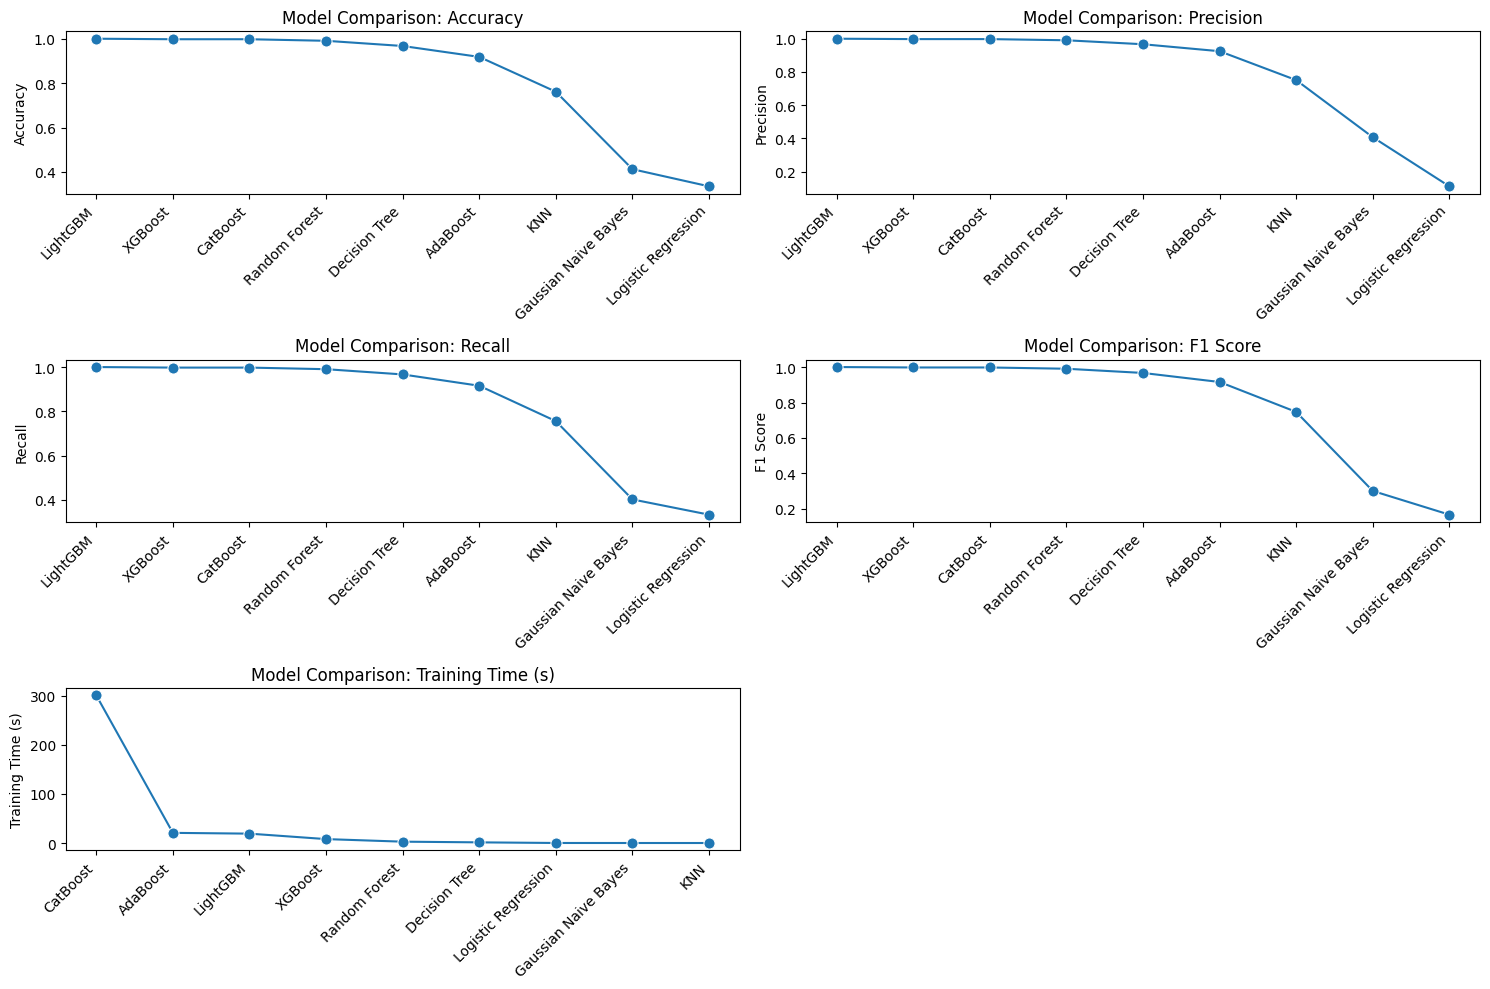

In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Define models
def get_models():
    return {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "Decision Tree": DecisionTreeClassifier(),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "AdaBoost": AdaBoostClassifier(n_estimators=100),
        "Gaussian Naive Bayes": GaussianNB(),
        "LightGBM": lgb.LGBMClassifier(),
        "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "CatBoost": cb.CatBoostClassifier(verbose=0)
    }

# Train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test):
    models = get_models()
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1 = report['macro avg']['f1-score']
        
        # Store results
        results[name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Training Time (s)": training_time
        }
        
        # Print results
        print(f"{name} Accuracy: {accuracy:.4f}")
        print(f"{name} Precision: {precision:.4f}")
        print(f"{name} Recall: {recall:.4f}")
        print(f"{name} F1 Score: {f1:.4f}")
        print(f"Training Time: {training_time:.4f} seconds\n")
    
    # Plot results
    plot_comparison(results)
    
    return results

# Function to plot comparison graphs
def plot_comparison(results):
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Training Time (s)"]
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 2, i)
        sorted_results = sorted(results.items(), key=lambda x: x[1][metric], reverse=True)
        models = [x[0] for x in sorted_results]
        scores = [x[1][metric] for x in sorted_results]
        
        sns.lineplot(x=models, y=scores, marker='o', linestyle='-', markersize=8)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(metric)
        plt.title(f'Model Comparison: {metric}')
        
    plt.tight_layout()
    plt.show()

# Example usage (assuming X_train, X_test, y_train, y_test are defined)
results = train_evaluate_models(X_train, X_test, y_train, y_test)


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Identify only FFT features
fft_features = [col for col in df.columns if col.startswith('fft_')]

# Step 2: Create a new DataFrame with only FFT features and the target
df_fft = df[fft_features + ['label']]  # Replace 'target' if your target column is named differently

# Step 3: Separate features and target
X = df_fft.drop(columns='label')
y = df_fft['label']
from sklearn.preprocessing import LabelEncoder

# Encode the target labels (NEGATIVE -> 0, NEUTRAL -> 1, POSITIVE -> 2)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Check encoding mapping
print("Label Encoding Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirmation
print(f"Shape of FFT X_train: {X_train.shape}")
print(f"Shape of FFT X_test: {X_test.shape}")


Label Encoding Mapping: {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
Shape of FFT X_train: (1705, 1500)
Shape of FFT X_test: (427, 1500)


Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.8173
Logistic Regression Precision: 0.8133
Logistic Regression Recall: 0.8131
Logistic Regression F1 Score: 0.8114
Training Time: 11.2351 seconds

Training Random Forest...
Random Forest Accuracy: 0.9508
Random Forest Precision: 0.9552
Random Forest Recall: 0.9486
Random Forest F1 Score: 0.9492
Training Time: 4.1754 seconds

Training Decision Tree...
Decision Tree Accuracy: 0.8595
Decision Tree Precision: 0.8562
Decision Tree Recall: 0.8568
Decision Tree F1 Score: 0.8560
Training Time: 2.2369 seconds

Training KNN...
KNN Accuracy: 0.9485
KNN Precision: 0.9515
KNN Recall: 0.9466
KNN F1 Score: 0.9470
Training Time: 0.0288 seconds

Training SVM...
SVM Accuracy: 0.8431
SVM Precision: 0.8401
SVM Recall: 0.8399
SVM F1 Score: 0.8398
Training Time: 6.1951 seconds

Training AdaBoost...
AdaBoost Accuracy: 0.5902
AdaBoost Precision: 0.5430
AdaBoost Recall: 0.5776
AdaBoost F1 Score: 0.5324
Training Time: 30.0147 seconds

Training Gaussian Naive Bayes...
Gaussian Nai

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

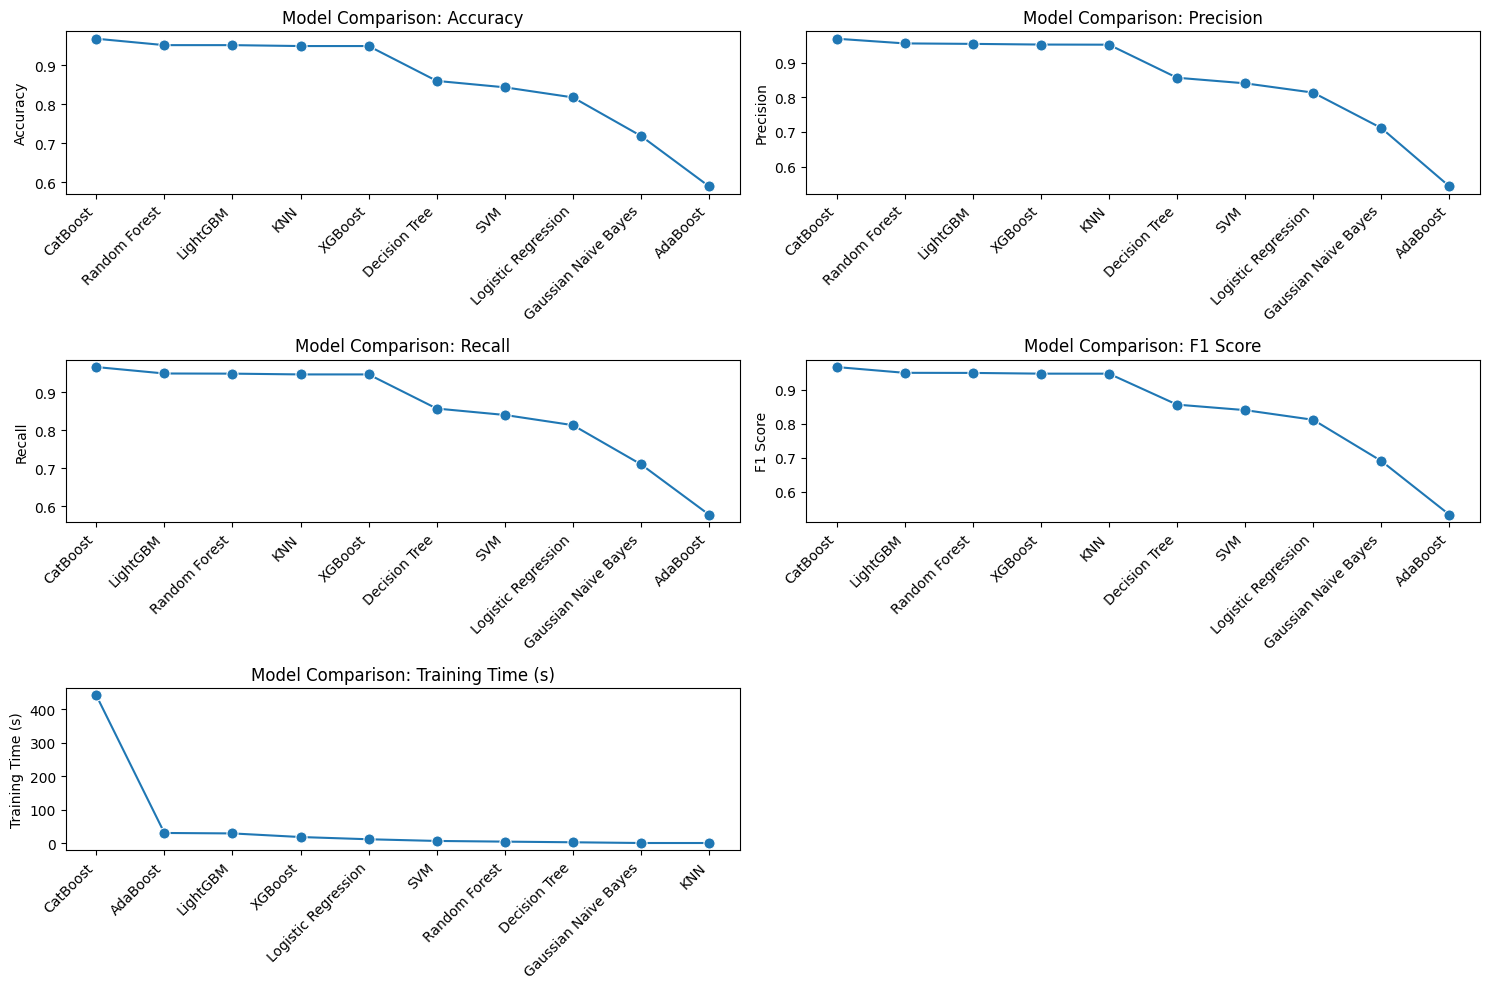

NameError: name 'in_test_split' is not defined

In [12]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Define models
def get_models():
    return {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "Decision Tree": DecisionTreeClassifier(),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "SVM": SVC(kernel='linear', probability=True),
        "AdaBoost": AdaBoostClassifier(n_estimators=100),
        "Gaussian Naive Bayes": GaussianNB(),
        "LightGBM": lgb.LGBMClassifier(),
        "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "CatBoost": cb.CatBoostClassifier(verbose=0)
    }

# Train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test):
    models = get_models()
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1 = report['macro avg']['f1-score']
        
        # Store results
        results[name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Training Time (s)": training_time
        }
        
        # Print results
        print(f"{name} Accuracy: {accuracy:.4f}")
        print(f"{name} Precision: {precision:.4f}")
        print(f"{name} Recall: {recall:.4f}")
        print(f"{name} F1 Score: {f1:.4f}")
        print(f"Training Time: {training_time:.4f} seconds\n")
    
    # Plot results
    plot_comparison(results)
    
    return results

# Function to plot comparison graphs
def plot_comparison(results):
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Training Time (s)"]
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 2, i)
        sorted_results = sorted(results.items(), key=lambda x: x[1][metric], reverse=True)
        models = [x[0] for x in sorted_results]
        scores = [x[1][metric] for x in sorted_results]
        
        sns.lineplot(x=models, y=scores, marker='o', linestyle='-', markersize=8)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(metric)
        plt.title(f'Model Comparison: {metric}')
        
    plt.tight_layout()
    plt.show()

# Example usage (assuming X_train, X_test, y_train, y_test are defined)
results = train_evaluate_models(X_train, X_test, y_train, y_test)
in_test_split(X, y, test_size=0.2, random_state=42)

# Confirmation
print(f"Shape of FFT X_train: {X_train.shape}")
print(f"Shape of FFT X_test: {X_test.shape}")



=== SVM ===
              precision    recall  f1-score   support

    NEGATIVE       0.86      0.98      0.92       142
     NEUTRAL       0.99      0.98      0.99       143
    POSITIVE       0.95      0.84      0.89       142

    accuracy                           0.93       427
   macro avg       0.94      0.93      0.93       427
weighted avg       0.94      0.93      0.93       427

Confusion Matrix:
 [[139   0   3]
 [  0 140   3]
 [ 22   1 119]]

=== Random Forest ===
              precision    recall  f1-score   support

    NEGATIVE       0.93      0.98      0.95       142
     NEUTRAL       0.98      0.99      0.99       143
    POSITIVE       0.97      0.90      0.93       142

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427

Confusion Matrix:
 [[139   0   3]
 [  0 142   1]
 [ 11   3 128]]

=== MLP ===
              precision    recall  f1-score   support

    

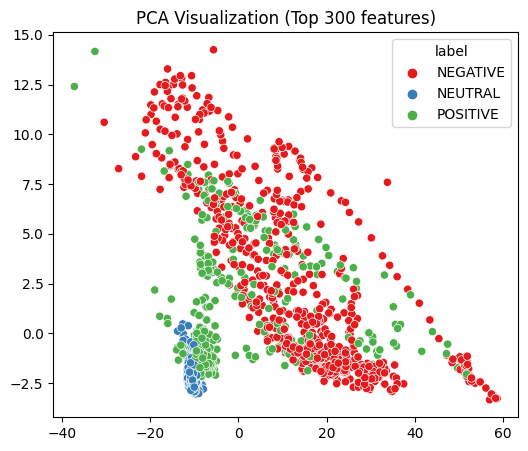

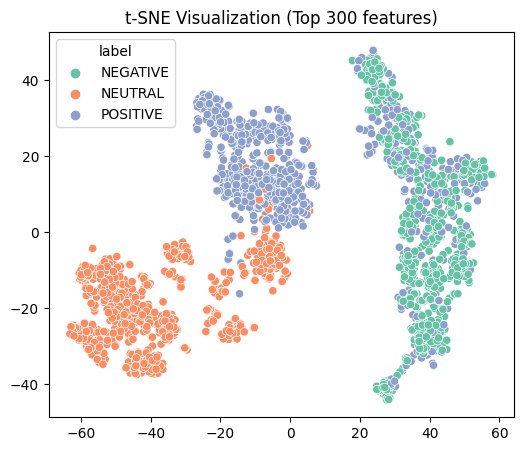

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Step 1: Load Data
# -----------------------------

# Set label for stress detection
label_col = 'label'
y = df[label_col]


X = df.drop(columns='label')

# -----------------------------
# Step 2: Normalize Features
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# Step 3: Feature Selection
# -----------------------------
# Select top 300 features using ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=300)
X_selected = selector.fit_transform(X_scaled, y)
selected_feature_names = X.columns[selector.get_support(indices=True)]

# -----------------------------
# Step 4: Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# Step 5: Train Classifiers
# -----------------------------
models = {
    "SVM": SVC(kernel='rbf', C=1),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -----------------------------
# Step 6: Feature Group Analysis
# -----------------------------
groups = ['covmat_', 'mean_', 'var_', 'asymmetry_', 'coherence_']
for g in groups:
    group_cols = [col for col in X.columns if g in col]
    if group_cols:
        Xg = scaler.fit_transform(df[group_cols])
        scores = cross_val_score(RandomForestClassifier(), Xg, y, cv=5)
        print(f"{g} feature group: mean accuracy = {np.mean(scores):.3f}")

# -----------------------------
# Step 7: Dimensionality Reduction Visualization
# -----------------------------
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set1')
plt.title("PCA Visualization (Top 300 features)")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_selected)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='Set2')
plt.title("t-SNE Visualization (Top 300 features)")
plt.show()



In [14]:
print("Top 300 selected features:")
print(selected_feature_names.tolist())


Top 300 selected features:
['# mean_0_a', 'mean_2_a', 'mean_3_a', 'mean_d_2_a2', 'mean_d_7_a', 'mean_d_12_a', 'mean_d_17_a', 'stddev_2_a', 'min_2_a', 'min_q_2_a', 'min_q_7_a', 'min_q_12_a', 'min_q_17_a', 'covmat_104_a', 'covmat_105_a', 'covmat_116_a', 'covmat_117_a', 'eigen_0_a', 'logm_0_a', 'logm_8_a', 'logm_9_a', 'logm_24_a', 'entropy0_a', 'entropy3_a', 'fft_0_a', 'fft_1_a', 'fft_4_a', 'fft_15_a', 'fft_16_a', 'fft_19_a', 'fft_30_a', 'fft_31_a', 'fft_34_a', 'fft_45_a', 'fft_46_a', 'fft_49_a', 'fft_60_a', 'fft_61_a', 'fft_64_a', 'fft_75_a', 'fft_76_a', 'fft_79_a', 'fft_90_a', 'fft_91_a', 'fft_94_a', 'fft_105_a', 'fft_106_a', 'fft_109_a', 'fft_120_a', 'fft_121_a', 'fft_124_a', 'fft_135_a', 'fft_136_a', 'fft_139_a', 'fft_151_a', 'fft_154_a', 'fft_181_a', 'fft_184_a', 'fft_196_a', 'fft_199_a', 'fft_211_a', 'fft_214_a', 'fft_226_a', 'fft_229_a', 'fft_241_a', 'fft_244_a', 'fft_256_a', 'fft_259_a', 'fft_270_a', 'fft_271_a', 'fft_274_a', 'fft_285_a', 'fft_286_a', 'fft_289_a', 'fft_300_a', 'ff